In [2]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from pyomo.environ import *
import time
import random
from geneticalgorithm import geneticalgorithm as ga


## Random Sampling and Grid Search

In [22]:
###Color palette
palette = sns.color_palette("Set2")[2:6]
palette.append(sns.color_palette("Set2")[1])

###Helper functions
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)
    
def solve_point(architecture, param_values):
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    return loss

def arch_converter(A):
    if A == 'Dual Control':
        return ((0, 1, 0), (1, 0, 0))

    elif A == 'No Control':
        return ((0, 0, 1), (0, 0, 1))

    elif A == 'Downstream Activation':
        return ((0, 0, 1), (1, 0, 0))

    elif A == 'Upstream Repression':
        return ((0, 1, 0), (0, 0, 1))
    else: return 'Invalid Circuit'

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

def gen_ics(N):
    #Set random seed
    np.random.seed(2022)
    ics = []
    for i in range(N):
        k1 = random.uniform(1E-7,1E-3)
        k2 = random.uniform(1E-7,1E-3)
        theta1 = random.uniform(0.001,10)
        theta2 = random.uniform(0.001,10)

        init_conds = [[2.,theta1, k1], [2., theta2, k2]]
        ics.append(init_conds)
    return ics

In [61]:
#1k random sampling triplicate
for num_samples in [1000, 1000, 1000]:
    replicate = 1
    overall_start_time = time.time()
    ics = gen_ics(num_samples)
    for A in ['Dual Control', 'Upstream Repression', 'Downstream Activation', 'No Control']:
        start_time = time.time()
        losses = []; k1_trace = []; k2_trace = []; n1_trace = []; n2_trace = []; theta1_trace = []; theta2_trace = []
        for j in range(len(ics)):
            init_conds = ics[j]
            [[new_n1,new_theta1, new_k1], [new_n2, new_theta2, new_k2]] = init_conds
            architecture = arch_converter(A)
            func = name_converter(architecture)
            loss = solve_point(architecture, init_conds)
            losses.append(loss)
            k1_trace.append(new_k1)
            k2_trace.append(new_k2)
            n1_trace.append(new_n1)
            n2_trace.append(new_n2)
            theta1_trace.append(new_theta1)
            theta2_trace.append(new_theta2)
        elapsed_time = time.time() - start_time
        results = pd.DataFrame({'circuit': func, 'num_samples': num_samples,'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace, 'time': elapsed_time})
        results.to_csv('random_sampling/'+func.lower().replace(' ', '_')+str(num_samples)+str(replicate)+'.csv')
    replicate = replicate + 1
    overall_elapsed = time.time() - overall_start_time
    print(overall_elapsed)

202.884831905365
206.4715609550476
196.88582491874695


In [26]:
#Grid search triplicate run
#Run single forward optimization grid search to create landscapes
architectures = [((0, 0, 1), (1, 0, 0)), ((0, 1, 0), (0, 0, 1)), ((0, 0, 1), (0, 0, 1)), ((0, 1, 0), (1, 0, 0))]
k1s = np.linspace(1E-7, 1E-3, 10)
k2s = np.linspace(1E-7, 1E-3, 10)
theta1s = np.linspace(0.001, 10, 10)
theta2s = np.linspace(0.001, 10, 10)
t = np.linspace(0, 5E4, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

landscape_grid = pd.DataFrame()
for architecture in architectures:
        start_time = time.time()
        for k1 in k1s:
                for k2 in k2s:
                        for theta1 in theta1s:
                                for theta2 in theta2s:
                                        param_values = [[2., theta1, k1], [2., theta2, k2]]
                                        extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
                                        ode_solver = ode('cvode', toy_model, **extra_options)
                                        solution = ode_solver.solve(t, y0)
                                        j1, j2 = solution.values.y[-1, -2:]
                                        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
                                        test = pd.DataFrame({'index':[0], 'architecture':name_converter(architecture), 'theta1':theta1, 'theta2':theta2, 'k1':k1, 'k2':k2, 'loss':loss})
                                        landscape_grid = pd.concat([landscape_grid, test])
        elapsed_time = time.time() - start_time
        landscape_grid['time'] = elapsed_time
        print(architecture, 'architecture complete')
        print(elapsed_time)
landscape_grid.to_csv('grid_search_landscape_times2.csv')

architectures = [((0, 0, 1), (1, 0, 0)), ((0, 1, 0), (0, 0, 1)), ((0, 0, 1), (0, 0, 1)), ((0, 1, 0), (1, 0, 0))]
k1s = np.linspace(1E-7, 1E-3, 10)
k2s = np.linspace(1E-7, 1E-3, 10)
theta1s = np.linspace(0.001, 10, 10)
theta2s = np.linspace(0.001, 10, 10)
t = np.linspace(0, 5E4, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

landscape_grid = pd.DataFrame()
for architecture in architectures:
        start_time = time.time()
        for k1 in k1s:
                for k2 in k2s:
                        for theta1 in theta1s:
                                for theta2 in theta2s:
                                        param_values = [[2., theta1, k1], [2., theta2, k2]]
                                        extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
                                        ode_solver = ode('cvode', toy_model, **extra_options)
                                        solution = ode_solver.solve(t, y0)
                                        j1, j2 = solution.values.y[-1, -2:]
                                        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
                                        test = pd.DataFrame({'index':[0], 'architecture':name_converter(architecture), 'theta1':theta1, 'theta2':theta2, 'k1':k1, 'k2':k2, 'loss':loss})
                                        landscape_grid = pd.concat([landscape_grid, test])
        elapsed_time = time.time() - start_time
        landscape_grid['time'] = elapsed_time
        print(architecture, 'architecture complete')
        print(elapsed_time)
landscape_grid.to_csv('grid_search_landscape_times3.csv')

((0, 0, 1), (1, 0, 0)) architecture complete
392.9051651954651
((0, 1, 0), (0, 0, 1)) architecture complete
396.50507378578186
((0, 0, 1), (0, 0, 1)) architecture complete
4065.115817785263
((0, 1, 0), (1, 0, 0)) architecture complete
357.0428900718689
((0, 0, 1), (1, 0, 0)) architecture complete
367.0357701778412
((0, 1, 0), (0, 0, 1)) architecture complete
369.8970539569855
((0, 0, 1), (0, 0, 1)) architecture complete
1226.934257030487
((0, 1, 0), (1, 0, 0)) architecture complete
366.0373980998993


## Dataframe construction

In [2]:
#Read in random sampling results
da100 = pd.read_csv('random_sampling/downstream_activation100.csv')
da1k = pd.read_csv('random_sampling/downstream_activation1000.csv')
da10k = pd.read_csv('random_sampling/downstream_activation10000.csv')

dc100 = pd.read_csv('random_sampling/dual_control100.csv')
dc1k = pd.read_csv('random_sampling/dual_control1000.csv')
dc10k = pd.read_csv('random_sampling/dual_control10000.csv')

nc100 = pd.read_csv('random_sampling/no_control100.csv')
nc1k = pd.read_csv('random_sampling/no_control1000.csv')
nc10k = pd.read_csv('random_sampling/no_control10000.csv')

ur100 = pd.read_csv('random_sampling/upstream_repression100.csv')
ur1k = pd.read_csv('random_sampling/upstream_repression1000.csv')
ur10k = pd.read_csv('random_sampling/upstream_repression10000.csv')

#Read in grid search results
grid_search_timings = pd.DataFrame({'circuit':['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control'], 'time':[375, 381, 395, 382]})
gs_losses = pd.read_csv('grid_search/grid_search_landscape_times.csv')

#Combine all into best loss/computational time dataframe
combined = pd.DataFrame(columns=['Method', 'Circuit', 'Computational Time', 'Best Loss'])

rs_times = [16.06, 159.24, 1682.93]
#Random sampling data processing
for df in [da100, da1k, da10k, dc100, dc1k, dc10k, nc100, nc1k, nc10k, ur100, ur1k, ur10k]:
    best_loss = df.loss.min()
    time = df.time[0]
    if str(df.num_samples[0]) == '100':
        method = '100 Random'
        time = rs_times[0]
    elif str(df.num_samples[0]) == '1000':
        method = '1k Random'
        time = rs_times[1]
    if str(df.num_samples[0]) == '10000':
        method = '10k Random'
        time = rs_times[2]
    row = pd.DataFrame({'Method': [method], 'Circuit': [df.circuit[0]], 'Computational Time':[time], 'Best Loss':[best_loss]})
    combined = pd.concat([combined, row])

#Grid search data processing
for c in ['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control']:
    df = gs_losses.loc[gs_losses.architecture == c]
    best_loss = df.loss.min()
    time = grid_search_timings.loc[grid_search_timings.circuit == c].reset_index(drop=True).iloc[0].time
    method = 'Grid Search'

    row = pd.DataFrame({'Method': [method], 'Circuit': [c], 'Computational Time':[time], 'Best Loss':[best_loss]})
    combined = pd.concat([combined, row])

combined

,Method,Circuit,Computational Time,Best Loss
0,100 Random,Downstream Activation,16.06,0.069727
0,1k Random,Downstream Activation,159.24,0.064796
0,10k Random,Downstream Activation,1682.93,0.062044
0,100 Random,Dual Control,16.06,0.071058
0,1k Random,Dual Control,159.24,0.064976
0,10k Random,Dual Control,1682.93,0.064236
0,100 Random,No Control,16.06,0.076973
0,1k Random,No Control,159.24,0.074628
0,10k Random,No Control,1682.93,0.063139
0,100 Random,Upstream Repression,16.06,0.121934


In [3]:
#Read and parse BO results
single_architecture = pd.read_csv('../toy_model/background.csv')
single_architecture = single_architecture.loc[single_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()
multi_architecture = pd.read_csv('../toy_model/background_fourarchitectures.csv')
multi_architecture = multi_architecture.loc[multi_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()

with open('bayesopt_timing_singlearch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

single_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

with open('bayesopt_timing_multiarch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

multi_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

bo_single = pd.merge(single_parsed, single_architecture, on='index')
bo_multi = pd.merge(multi_parsed, multi_architecture, on='index')

## Visualization

In [9]:
visualization_data = pd.DataFrame({'Method':[], 'Computational Time':[], 'Computational Time STD':[], 'Best Loss':[], 'Best Loss STD':[],'Function Evaluations':[]})

In [10]:
### NAIVE APPROACH
# #Read in random sampling results
# da100 = pd.read_csv('random_sampling/downstream_activation100.csv')
# da1k = pd.read_csv('random_sampling/downstream_activation1000.csv')
# da10k = pd.read_csv('random_sampling/downstream_activation10000.csv')

# dc100 = pd.read_csv('random_sampling/dual_control100.csv')
# dc1k = pd.read_csv('random_sampling/dual_control1000.csv')
# dc10k = pd.read_csv('random_sampling/dual_control10000.csv')

# nc100 = pd.read_csv('random_sampling/no_control100.csv')
# nc1k = pd.read_csv('random_sampling/no_control1000.csv')
# nc10k = pd.read_csv('random_sampling/no_control10000.csv')

# ur100 = pd.read_csv('random_sampling/upstream_repression100.csv')
# ur1k = pd.read_csv('random_sampling/upstream_repression1000.csv')
# ur10k = pd.read_csv('random_sampling/upstream_repression10000.csv')

# #Combine all into best loss/computational time dataframe
# combined = pd.DataFrame(columns=['Method', 'Circuit', 'Computational Time', 'Best Loss'])


# rs_times = [16.06, 159.24, 1682.93]
# #Random sampling data processing
# for df in [da100, da1k, da10k, dc100, dc1k, dc10k, nc100, nc1k, nc10k, ur100, ur1k, ur10k]:
#     best_loss = df.loss.min()
#     time = df.time[0]
#     if str(df.num_samples[0]) == '100':
#         method = '100 Random'
#         time = rs_times[0]
#     elif str(df.num_samples[0]) == '1000':
#         method = '1k Random'
#         time = rs_times[1]
#     if str(df.num_samples[0]) == '10000':
#         method = '10k Random'
#         time = rs_times[2]
#     row = pd.DataFrame({'Method': [method], 'Circuit': [df.circuit[0]], 'Computational Time':[time], 'Best Loss':[best_loss]})
#     combined = pd.concat([combined, row])
    
# #for m, num_iters in zip(['100 Random', '1k Random', '10k Random'], [100, 1000, 10000]):
# for m, num_iters in zip(['1000 Random'], [1000]):
#     m_df = combined.loc[combined.Method == m]
#     total_time = np.sum(m_df['Computational Time'])
#     best_loss = m_df['Best Loss'].min()
#     row = pd.DataFrame({'Method': ['Naive Approach'+' '+m], 'Computational Time': [total_time], 'Best Loss': [best_loss], 'Function Evaluations': [4*num_iters]})
#     visualization_data = pd.concat([visualization_data, row])



rs_times = [202.884831905365, 206.4715609550476, 196.88582491874695]
best_loss_avg = []
for i in ['1', '', '3']:
    losses = []
    for func in ['no_control', 'upstream_repression', 'downstream_activation', 'dual_control']:
        data = pd.read_csv('random_sampling/'+func+str(1000)+i+'.csv')
        best_loss = data.loss.min()
        losses.append(best_loss)
    best_loss_overall = np.min(losses)
    best_loss_avg.append(best_loss_overall)

row = pd.DataFrame({'Method': ['Naive Approach'], 'Computational Time': [np.mean(rs_times)], 'Computational Time STD':[np.std(rs_times)], 'Best Loss': [np.mean(best_loss_avg)], 'Best Loss STD': [np.std(best_loss_avg)],'Function Evaluations': [4000]})
visualization_data = pd.concat([visualization_data, row])

In [12]:
###EXHAUSTIVE SEARCH
#Read in grid search results
grid_search_timings = pd.DataFrame({'circuit':['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control'], 'time':[375, 381, 395, 382]})

best_losses = [] 
best_times = []
#Grid search data processing
for i in ['', '2', '3']:
    gs_losses = pd.read_csv('grid_search/grid_search_landscape_times'+i+'.csv')
    combined = pd.DataFrame(columns=['Method', 'Circuit', 'Computational Time', 'Best Loss'])
    losses = []; times = []
    for c in ['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control']:
        df = gs_losses.loc[gs_losses.architecture == c]
        best_loss = df.loss.min()
        if i == '':
            time = grid_search_timings.loc[grid_search_timings.circuit == c].reset_index(drop=True).iloc[0].time
        else: time = gs_losses.time.min()
        losses.append(best_loss)
        times.append(time)
    best_time = np.sum(times)
    best_loss = np.min(losses)
    best_times.append(best_time)
    best_losses.append(best_loss)
row = pd.DataFrame({'Method': ['Exhaustive Search'], 'Computational Time': [np.mean(best_times)], 'Computational Time STD':[np.std(best_times)], 'Best Loss': [np.mean(best_losses)], 'Best Loss STD':[np.std(best_losses)], 'Function Evaluations': 40000})
visualization_data = pd.concat([visualization_data, row])

In [17]:
###GRADIENT-BASED METHOD
#read in GB results
gb_results = pd.read_csv('nlp_100_fixed.csv')

import itertools
gb_results['Architecture'] = [list(zip(np.arange(400), itertools.cycle(['Dual Control', 'Upstream Repression', 'Downstream Activation', 'No Control'])))[i][1] for i in range(400)]

#Split into 100 experiments
start = 0
best_losses = []
times = []
fevs = []
for j in range(100):
    df = gb_results.iloc[start:start+4]
    start += 4

    best_losses.append(df['Best Loss'].min())
    times.append(df['Computational Time'].sum())
    fevs.append(df['Function Evaluations'].sum())
row = pd.DataFrame({'Method': ['Gradient-Based'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(best_losses)], 'Best Loss STD':[np.std(best_losses)], 'Function Evaluations': [np.mean(fevs)]})
visualization_data = pd.concat([visualization_data, row])


In [18]:
# ### GLOBAL OPTIMIZATION - OLD DATA
# #Clean genetic algorithm data of runtimes etc
# filenames = ['ga_samplerun.txt', 'ga_samplerun2.txt', 'ga_samplerun3.txt']
# times = []
# losses = []
# for filename in filenames:
#     with open('ga_samplerun.txt') as f:
#         lines = f.readlines()

#     total_time = int(lines[3].split('m')[0])*60 + int(lines[3].split(' ')[1].split('s')[0])
#     times.append(total_time)

#     best_loss = float(lines[-2].split(' ')[1].split(',')[0])
#     losses.append(best_loss)
# row = pd.DataFrame({'Method': ['Global Optimization'], 'Computational Time': [np.mean(times)], 'Best Loss': [np.mean(losses)], 'Function Evaluations': [100000]})
# visualization_data = pd.concat([visualization_data, row])

### GLOBAL OPTIMIZATION - NEW DATA
# row = pd.DataFrame({'Method': ['Global Optimization'], 'Computational Time': 84*60+59, 'Best Loss': 0.010989655947548624, 'Function Evaluations': [100000]})
# row = pd.DataFrame({'Method': ['Global Optimization'], 'Computational Time': 22*60+23, 'Best Loss': 0.04899464778034543, 'Function Evaluations': [100000]})
best_losses = []
times = []
for i in ['1','2','3']:
    go_results = pd.read_csv('genetic_algorithm/ga_result_rep'+i+'.txt')
    go_results = go_results.loc[go_results.loss > 0]
    times.append(go_results['Computational Time'].min())
    best_losses.append(go_results['loss'].min())
row = pd.DataFrame({'Method': ['Global Optimization'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(best_losses)], 'Best Loss STD':[np.std(best_losses)], 'Function Evaluations': [100000]})
visualization_data = pd.concat([visualization_data, row])

In [19]:
###BAYESIAN OPTIMIZATION
#Read and parse BO results
single_architecture = pd.read_csv('../toy_model/background.csv')
single_architecture = single_architecture.loc[single_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()
multi_architecture = pd.read_csv('../toy_model/background_fourarchitectures.csv')
multi_architecture = multi_architecture.loc[multi_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()

with open('bayesopt_timing_singlearch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

single_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

with open('bayesopt_timing_multiarch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

multi_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

bo_single = pd.merge(single_parsed, single_architecture, on='index')
bo_multi = pd.merge(multi_parsed, multi_architecture, on='index')

row = pd.DataFrame({'Method': ['Bayesian Optimization'], 'Computational Time': [bo_multi['Computational Time'].mean()], 'Computational Time STD': [bo_multi['Computational Time'].std()], 'Best Loss': [bo_multi['best_losses'].min()], 'Best Loss STD': [bo_multi['best_losses'].std()],'Function Evaluations': 1000})
visualization_data = pd.concat([visualization_data, row])

In [20]:
visualization_data = visualization_data.reset_index(drop=True)
visualization_data['Method Name'] = [visualization_data.Method[i].split(' 1')[0] for i in range(len(visualization_data))]
visualization_data

,Method,Computational Time,Computational Time STD,Best Loss,Best Loss STD,Function Evaluations,Method Name
0,Naive Approach,202.080739,3.954450,0.064829,0.000992,4000.0,Naive Approach
1,Exhaustive Search,1475.107051,43.491761,0.065600,0.000000,40000.0,Exhaustive Search
2,Gradient-Based,64.431016,284.950932,0.073110,0.018503,766.9,Gradient-Based
3,Global Optimization,1627.165643,226.825220,0.054322,0.006667,100000.0,Global Optimization
4,Bayesian Optimization,27.050000,0.891883,0.060877,0.001417,1000.0,Bayesian Optimization


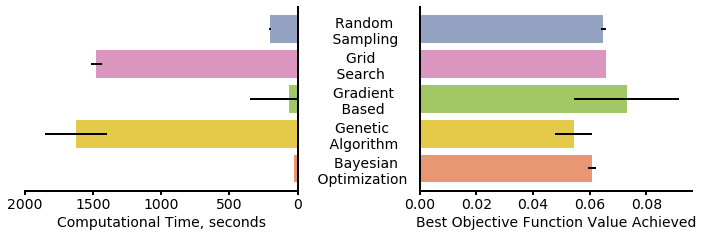

In [43]:
###FIGURE: Benchmarking results
fig, axs = plt.subplots(1,2,figsize=(10, 3.4))
ax = axs[0]
plot = sns.barplot(data=visualization_data, x='Computational Time', y='Method', hue='Method', palette=palette, ax=ax, dodge=False)
ax.hlines([0, 1, 2, 3, 4], [visualization_data['Computational Time'] - visualization_data['Computational Time STD']], [visualization_data['Computational Time'] + visualization_data['Computational Time STD']],  linewidth=2)

plot.set(yticklabels=[])
plot.legend_.remove()
ax.set_xlim([2000, 0])
ax.tick_params(axis='x', labelsize=14)
for axis in ['top','left','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(width=2)
ax.set_ylabel('')
ax.set_xlabel('Computational Time, seconds', fontsize =14)
ax.set_yticks([])

ax = axs[1]
plot = sns.barplot(data=visualization_data, x='Best Loss', y='Method', hue='Method Name', palette=palette, ax=ax, dodge=False)
ax.hlines([0, 1, 2, 3, 4], [visualization_data['Best Loss'] - visualization_data['Best Loss STD']], [visualization_data['Best Loss'] + visualization_data['Best Loss STD']],  linewidth=2)

plot.set(yticklabels=['Random     \n Sampling    ','Grid         \n Search       ', 'Gradient     \n Based       ', 'Genetic      \n Algorithm    ', 'Bayesian    \n Optimization  '])
plot.legend_.remove()
ax.tick_params(axis='y', labelsize=14, length=0)
ax.tick_params(axis='x', labelsize=14)
for axis in ['top','left','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.tick_params(width=2)
ax.set_ylabel('')
ax.set_xlabel('Best Objective Function Value Achieved', fontsize =14)
plt.tight_layout()
#fig.savefig('benchmark.png', dpi=500, bbox_inches='tight', pad_inches=0.)
